# Разработка модели машинного обучения для персонализации предложений клиентам интернет-магазина «В один клик».

**Описание проекта:**\
Интернет-магазин «В один клик» предлагает широкий ассортимент товаров: для детей, для дома, бытовую технику, косметику и продукты. Недавний отчёт компании показал снижение активности постоянных клиентов. Привлечение новых клиентов становится всё менее эффективным, поэтому руководство решило сосредоточиться на удержании текущих покупателей. Для этого планируется внедрение персонализированных предложений, основанных на данных и моделях машинного обучения.

Цель проекта — разработка модели машинного обучения, предсказывающей вероятность снижения покупательской активности клиентов в течение следующих трёх месяцев. Это позволит сегментировать покупателей и создать индивидуальные маркетинговые стратегии для повышения их вовлечённости.

**Цель:**\
Создание прогнозной модели машинного обучения:

- Модель прогнозирования вероятности снижения покупательской активности клиента.
- Выделение сегментов клиентов на основе прогнозов модели и данных о прибыльности.
- Разработка рекомендаций для повышения активности клиентов.

**Ход исследования:**

- **Подготовка данных:** загрузка и изучение предоставленных данных о клиентах, их активности, покупательском поведении и взаимодействиях с магазином. Оценка структуры и качества данных.
- **Предобработка данных:** обработка пропущенных значений, корректировка типов данных, устранение дубликатов.
- **Анализ данных:** исследовательский анализ признаков, выявление закономерностей, аномалий и особенностей распределения.
- **Корреляционный анализ:** изучение взаимосвязей между признаками, оценка мультиколлинеарности.
- **Разработка модели прогнозирования покупательской активности:** обучение нескольких моделей (логистическая регрессия, деревья решений, метод k-ближайших соседей, метод опорных векторов), оценка их качества и анализ результатов.
- **Выбор лучшей модели:** использование метрики качества, подбор гиперпараметров, сравнение моделей.
- **Анализ важности признаков:** определение значимости различных факторов, влияющих на снижение покупательской активности.
- **Сегментация покупателей:** выделение ключевых групп клиентов, разработка персонализированных предложений для каждой из них.
- **Формирование рекомендаций:** создание стратегии удержания клиентов на основе полученных данных.

**Общий вывод:**\
Разработанная модель машинного обучения позволит интернет-магазину «В один клик» предсказывать снижение покупательской активности и применять персонализированные стратегии для удержания клиентов. Сегментация клиентов и анализ значимости факторов помогут создать более эффективные маркетинговые кампании, увеличить лояльность покупателей и повысить доход компании.

**Описание данных:**\
`market_file.csv` — данные о покупательском поведении клиентов на сайте, коммуникациях с клиентами и их предпочтениях в товарах.

`market_money.csv` — данные о выручке, полученной от клиентов.

`market_time.csv` — данные о времени, проведённом клиентами на сайте.

`money.csv` — данные о средней прибыли от каждого клиента за последние три месяца.

In [1]:
pip install -U scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap
import re

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

#Установка единого формата данных
pd.options.display.float_format = '{:,.3f}'.format
pd.options.mode.chained_assignment = None

RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

In [4]:
def data_info(data):
    display(data.head(2))
    data.info()
    display(data.describe())

In [5]:
market_file = pd.read_csv('/initial_data/market_file.csv', sep=',')
data_info(market_file)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.400,5,121,0.000,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.400,4,819,0.750,Товары для детей,4,4,2,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,"1,300.000","1,300.000","1,300.000","1,300.000","1,300.000","1,300.000","1,300.000","1,300.000","1,300.000"
mean,"215,997.500",4.254,4.012,601.898,0.320,3.270,2.840,4.185,8.177
std,375.422,1.015,0.697,249.856,0.250,1.355,1.971,1.955,3.978
min,"215,348.000",0.900,3.000,110.000,0.000,1.000,0.000,0.000,1.000
25%,"215,672.750",3.700,4.000,405.500,0.170,2.000,1.000,3.000,5.000
50%,"215,997.500",4.200,4.000,606.000,0.240,3.000,3.000,4.000,8.000
75%,"216,322.250",4.900,4.000,806.000,0.300,4.000,4.000,6.000,11.000
max,"216,647.000",6.600,5.000,"1,079.000",0.990,6.000,10.000,9.000,20.000


Первичный общий анализ данных в таблице `market_file` показал, что:

 - в данных нет пропусков
 - типы данных соответствуют информации в таблице
 - часть полей дискретны, т.к. содержат тоько целочисленные значения: `Маркет_актив_тек_мес `, `Длительность`, `Средний_просмотр_категорий_за_визит`, `Неоплаченные_продукты_штук_квартал`, `Ошибка_сервиса`, `Страниц_за_визит`.
 - Среднее значение в поле `Акционные_покупки` значительно отличается от медианного, что может свидетельствовать о наличии выбросов.  

In [6]:
market_money = pd.read_csv('/initial_data/market_money.csv', sep=',', decimal=',')
data_info(market_money)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3900 non-null   int64 
 1   Период   3900 non-null   object
 2   Выручка  3900 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.5+ KB


,id
count,"3,900.000"
mean,"215,997.500"
std,375.326
min,"215,348.000"
25%,"215,672.750"
50%,"215,997.500"
75%,"216,322.250"
max,"216,647.000"


Первичный общий анализ таблицы `market_money` показал, что тип данных в поле `Выручка` не соответствует содержащейся информации. Изменим тип на корректный при предобработке данных. Пропусков в таблице нет.

In [7]:
market_time = pd.read_csv('/initial_data/market_time.csv', sep=',')
data_info(market_time)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,минут
count,"2,600.000","2,600.000"
mean,"215,997.500",13.336
std,375.350,4.080
min,"215,348.000",4.000
25%,"215,672.750",10.000
50%,"215,997.500",13.000
75%,"216,322.250",16.000
max,"216,647.000",23.000


Первичный общий анализ таблицы `market_time` показал, что:
- в данных нет пропусков
- данные в поле `минут` имеют дискретный характер
- типы данных соответствуют информации в таблице
- среднее значение и медиана близки, вероятно, в данных нет значительных выбросов и аномалий

In [8]:
money = pd.read_csv('/initial_data/money.csv', sep=';', decimal=',')
data_info(money)

,id,Прибыль
0,215348,0.980
1,215349,4.160


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
count,"1,300.000","1,300.000"
mean,"215,997.500",3.997
std,375.422,1.014
min,"215,348.000",0.860
25%,"215,672.750",3.300
50%,"215,997.500",4.045
75%,"216,322.250",4.670
max,"216,647.000",7.430


Первичный общий анализ таблицы `money` показал, что:
- в данных нет пропусков
- типы данных соответствуют информации в таблице
- среднее значение и медиана близки, вероятно, в данных нет значительных выбросов и аномалий

<b>Вывод по разделу "Загрузка данных"</b>

- Данные в таблицах соответствуют описанию. 
- При загрузке подобраны необходимые разделители значений и десятичных значений.
- Требуется сменить тип данных для колонки `Выручка` в таблице `market_money`.

## Предобработка данных

Приведем все названия столбцов к единому формату в соответстветсвии с общепринятым "змеиным_регистром".

In [9]:
# market_file.rename(columns={'Покупательская активность': 'Покупательская_активность',
#                             'Тип сервиса': 'Тип_сервиса',
#                             'Разрешить сообщать': 'Разрешить_сообщать'}, inplace=True) 
# market_file.head(2)

In [10]:
dfS = [
    market_file,
    market_money,
    market_time,
    money
]

for df in dfS:
    df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).replace(' ', '_').lower() for i in df.columns]
    
#check
print(market_file.columns)
print(market_money.columns)
print(market_time.columns)
print(money.columns)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
Index(['id', 'период', 'выручка'], dtype='object')
Index(['id', 'период', 'минут'], dtype='object')
Index(['id', 'прибыль'], dtype='object')


Проверим данные на наличие пропусков, явных и неявных дубликатов.

In [11]:
def data_check(data, id_column = 'id'):
    '''Проверка на наличие пропусков и вывод уникальных значений категориальных признаков'''
    for column in data.columns:
        if data[column].isna().sum() > 0:
            print(f'В поле {сolumn} есть пропуски в данных: {data[column].isna().sum()} строк') 
        if data[column].dtype == 'object':
            data[column] = data[column].str.lower()
            print(f'Значения в поле "{column}":', data[column].unique())   
    print('______________')
    '''Проверка на наличие явных дубликатов'''
    if data.duplicated().sum() > 0:
        print(f'В данных есть явные дубликаты: {data.duplicated().sum()} строк')
    print('______________')
    if data[id_column].nunique() == data.shape[0]:
        print('Все значения в поле с идентификатором уникальны')
    else:
        print('В поле с идентификатором есть дубликаты')

In [12]:
data_check(market_file)

Значения в поле "покупательская_активность": ['снизилась' 'прежний уровень']
Значения в поле "тип_сервиса": ['премиум' 'стандартт' 'стандарт']
Значения в поле "разрешить_сообщать": ['да' 'нет']
Значения в поле "популярная_категория": ['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']
______________
______________
Все значения в поле с идентификатором уникальны


В датасете `market_file` нет явных дубликатов и пропусков, но есть неявные дубликаты в поле `тип_сервиса`: 'стандартт' = 'стандарт'. Устраним эти дубликаты.

In [13]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].str.replace('стандартт', 'стандарт')
market_file['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

Также есть опечатка в значениях в колонке `популярная_категория`: заменим значение `косметика и аксесуары` на корректное `косметика и аксесcуары`

In [14]:
market_file['популярная_категория'] = market_file['популярная_категория'].str.replace('косметика и аксесуары', 'косметика и аксесcуары')
market_file['популярная_категория'].unique()

array(['товары для детей', 'домашний текстиль', 'косметика и аксесcуары',
       'техника для красоты и здоровья', 'кухонная посуда',
       'мелкая бытовая техника и электроника'], dtype=object)

In [15]:
data_check(market_money)

Значения в поле "период": ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
Значения в поле "выручка": ['0.0' '3293.1' '4472.0' ... '5224.6' '4720.0' '4448.3']
______________
______________
В поле с идентификатором есть дубликаты


В датасете `market_money` нет явных дубликатов и пропусков. Есть несоответствие типа данных в поле `выручка`, заменим тип на корректный float. 

In [16]:
market_money['выручка'] = market_money['выручка'].astype(float)
market_money['выручка'].dtype

dtype('float64')

В поле `Период` есть 3 значения 'препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц'. Вероятно, в данном случае имеются в виду наблюдения за 3 месяца. Проверим распределение количества наблюдений по данному признаку.

In [17]:
market_money['период'].value_counts()

предыдущий_месяц       1300
текущий_месяц          1300
препредыдущий_месяц    1300
Name: период, dtype: int64

В данных есть дубликаты в поле `id`, но это объяснимо с учетом того, что данные по одним и тем же пользователям собирались за несколько периодов. Учитывая, что количество периодов = 3, каждый идентификатор не должен встречаться большее количество раз.

In [18]:
market_money['id'].value_counts().max()

3

In [19]:
data_check(money)

______________
______________
Все значения в поле с идентификатором уникальны


В датасете `money` нет дубликатов, пропусков и несоответсвий в типах данных.

In [20]:
data_check(market_time)

Значения в поле "период": ['текущий_месяц' 'предыдцщий_месяц']
______________
______________
В поле с идентификатором есть дубликаты


В датасете `market_time` нет явных дубликатов и пропусков, но есть опечатка. в поле `Период`: 'предыдцщий_месяц' = 'предыдущий_месяц'. Устраним эту неточность.

In [21]:
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Здесь также есть дубликаты в поле `id`, а количество периодов = 2. Следовательно, каждый идентификатор не должен встречаться более 2 раз. Проверим.

In [22]:
market_time['id'].value_counts().max()

2

<b>Вывод по разделу "Предобработка данных"</b>

В ходе предобработки:
- имена колонок в таблице `market_file` приведены к единому формату, соответствующему общепринятому "змеиному_регистру".
- удалены неявные дубликаты и неточности в полях `Период` и `Тип_сервиса`.
- изменен тип данных в поле `Выручка` на соответствующий данным тип float

## Исследовательский анализ данных

Согласно заданию нам необходимо проанализировать только клиентов, которые что-либо приобретали в интернет-магазине в последние 3 месяца. Данные о продажах содержатся в таблице `market_money`. Проверим есть ли в таблице такие клиенты, которые ничего не приобретали (выручка = 0). И все ли нужные id представлены в других таблицах.

In [23]:
print('Минимальная выручка по клиенту за 3 месяца:', \
      market_money.pivot_table(index='id', values='выручка', aggfunc='sum')['выручка'].min())

Минимальная выручка по клиенту за 3 месяца: 3293.1


In [24]:
id_clients = market_money['id'].unique()
print('Количество клиентов, совершавших покупки в последние 3 месяца:', len(id_clients))

Количество клиентов, совершавших покупки в последние 3 месяца: 1300


In [25]:
print('Количество клиентов совершавших покупки в датасете market_file:', \
      market_file.query('id in @id_clients')['id'].nunique())
print('Количество клиентов совершавших покупки в датасете market_time :', \
      market_time.query('id in @id_clients')['id'].nunique())
print('Количество клиентов, совершавших покупки в датасете money:', \
      money.query('id in @id_clients')['id'].nunique())

Количество клиентов совершавших покупки в датасете market_file: 1300
Количество клиентов совершавших покупки в датасете market_time : 1300
Количество клиентов, совершавших покупки в датасете money: 1300


Количество отобранных id совпадает с размером датасетов. Все клиенты совершавшие покупки в последние 3 месяца включены в исследуемые данные. Дополнительная фильтрация не требуется.

Исследуем сперва категориальные переменные. Большинство категориальных признаков принимает только 2 значения, поэтому для визуализации хорошо подойдет круговая диаграмма. Для наглядности добавим на диаграмму как абсолютные значения, так и в долях.

In [26]:
def category_graph(data, columns):
    for column in columns:
        values = data.value_counts(column)
        ax = values.plot.pie(
            autopct=lambda x: f'{x:.1f}%\n({(x * sum(values) / 100).round(0)})',
            startangle=90,
            ylabel='',       
            title=f'Соотношение значений в поле "{column}"'
        )
        plt.show()

In [27]:
market_file.head(2)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,снизилась,премиум,да,3.400,5,121,0.000,товары для детей,6,2,1,5
1,215349,снизилась,премиум,да,4.400,4,819,0.750,товары для детей,4,4,2,5


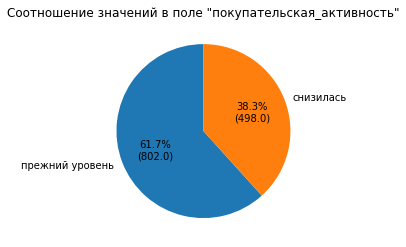

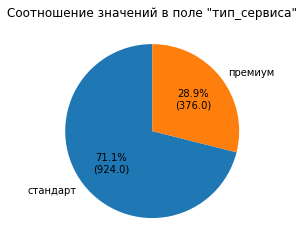

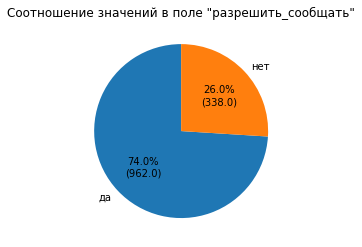

In [28]:
columns = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать']
category_graph(market_file, columns)

Около 30% клиентов имеют уровень сервиса "премиум". Большая часть покупателей (74%) дала согласие на получение информации о дополнительных предложениях компании.

Покупательская активность снизилась у 38% клиентов. Отметим, что покупательская активность - целевой признак. Т.к. соотношения значений в данном поле не 50/50, мы можем говорить о **дисбалансе классов**. При дисбалансе классов accuracy покажет неадекватно высокое качество модели, т.к. она не обращает внимание на плохо предсказанную принадлежность к минорному классу, а f1-мера напротив "занизит" качество модели, т.к. представляет собой среднее гармоническое precision и recall. Эти метрики при подборе подходящей стоит сразу исключить.

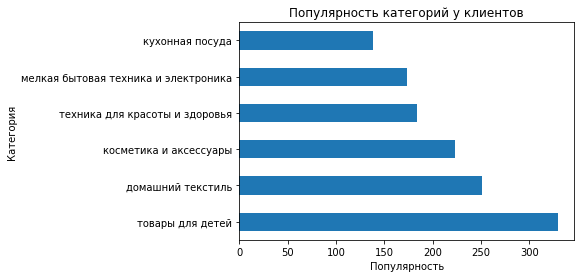

In [29]:
ax = market_file.value_counts('популярная_категория').plot.barh()
plt.title('Популярность категорий у клиентов')
plt.xlabel('Популярность')
plt.ylabel('Категория')
plt.show()

Самая популярная категория среди клиентов - товары для детей. Возможно, аудитория включает много семей с детьми, а такие товары часто покупаются регулярно (игрушки, одежда, подгузники). Самая непопулярная - кухонная посуда. Что в целом объяснимо: люди покупают её не так часто, так как она служит долго, а спрос возникает только при необходимости замены или обновления.

Проанализируем количественные признаки в каждом датасете. По итогам анализа в разделе с загрузкой данных было отмечено, что часть количественных данных имеет дискретный характер. Для построения гистограммы на непрерывных данных используем метод hist(), для дискретных - .plot(kind='bar'). Исключение колонка `Длительность` - несмотря на лискретную природу данных, количество значений достаточно велико, чтобы построить гистограмму hist().

In [30]:
def numeric_graph(data, num_columns, exception_columns):
    for column in num_columns:
        if data[column].dtype == 'float' or [column] == exception_columns:
            data[column].hist()
            plt.title(f'Гистограмма распределения в поле "{column}"')
            plt.xlabel('Значение')
            plt.ylabel('Количество клиентов')
            plt.show()   
        else:
            data[column].value_counts().sort_index().plot(kind='bar') 
            plt.title(f'Гистограмма распределения в поле "{column}"')
            plt.xlabel('Значение')
            plt.ylabel('Количество клиентов')
            plt.show()
        
        data[column].plot(kind='box')
        plt.title(f'Разброс значений признаков в поле "{column}"')
        plt.grid(True)
        plt.show()

In [31]:
market_file = market_file.set_index('id')

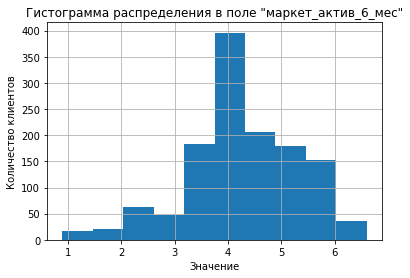

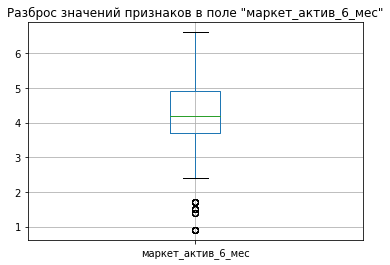

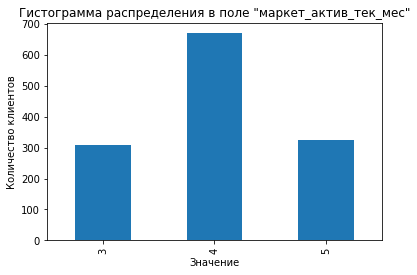

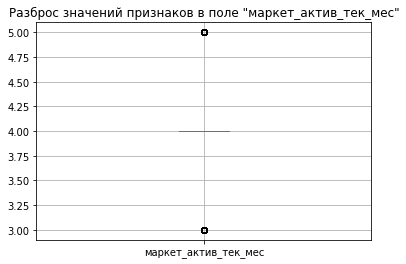

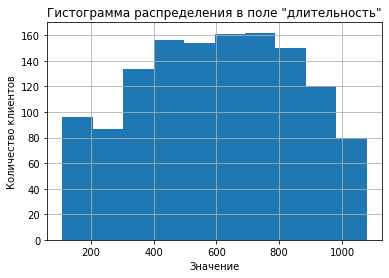

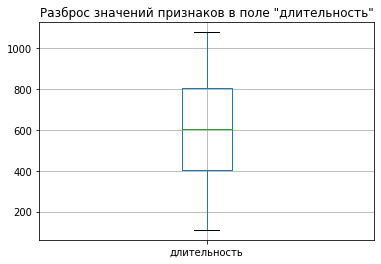

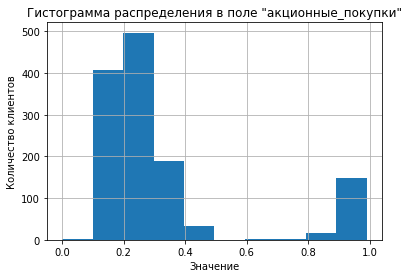

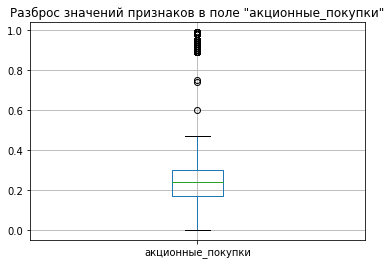

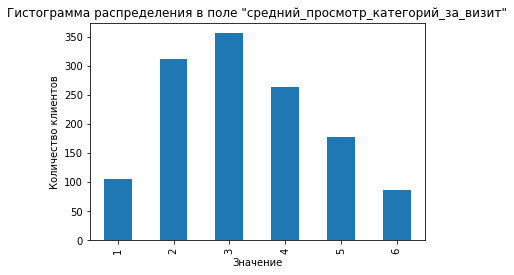

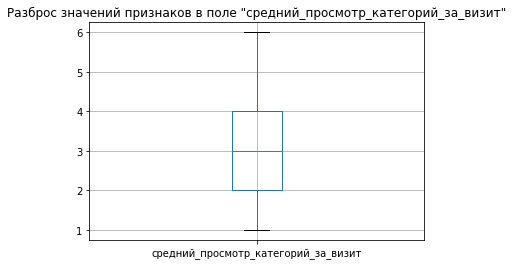

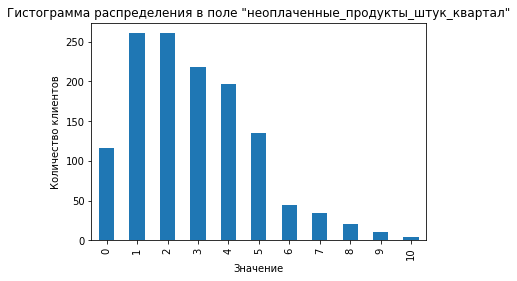

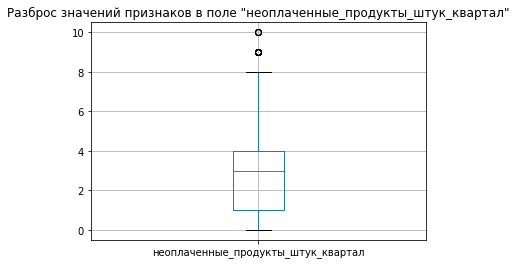

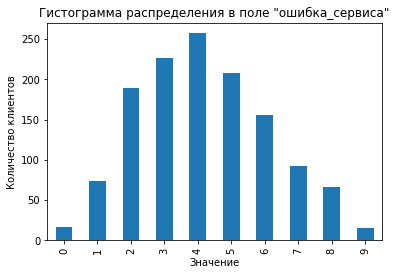

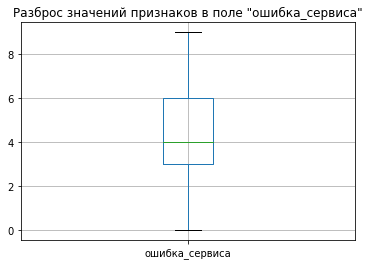

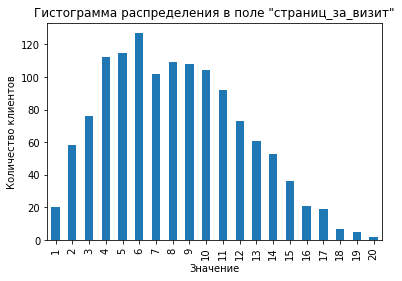

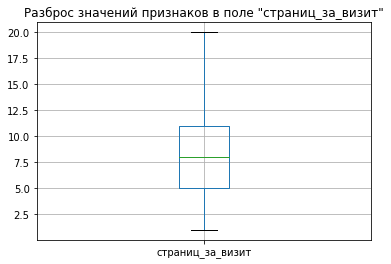

In [32]:
num_columns = market_file.select_dtypes(include='number')
exception_columns = ['длительность']
numeric_graph(market_file, num_columns, exception_columns)

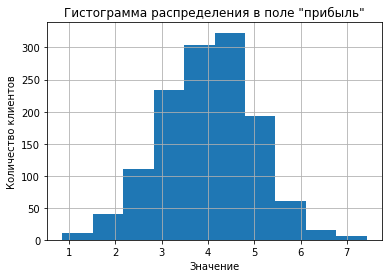

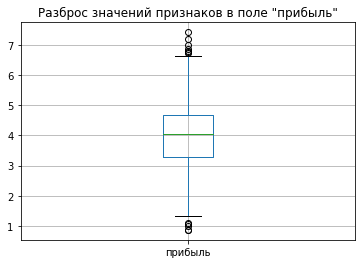

In [33]:
num_columns = ['прибыль']
numeric_graph(money, num_columns, exception_columns=[])

Краткие выводы по результатам визуализации:

**Маркет_актив_6_мес**
Чаще всего среднемесячное значение коммуникаций на покупателя составляет 4 активности. 1 или 2 коммуникации на клиента приходятся в редких случаях, что подтверждается попаданием этих значений в выбросы на графике "ящик с усами". Однако такая ситуация вполне возможно и не является явной аномалией. Удалять выбросы не будем, т.к. они обусловлены особенностями данных.

**Маркет_актив_тек_мес**
Распределение имеет пиковое значение = 4, что совпадает с наиболее распространенным значением при расчете среднемесячного значения коммуникаций. Здесь значения 3 и 5 также не являются выбросами.

**Длительность**
Распределение пользователей по количеству дней с момента регистрации на сайте достаточно равномерное, без ярко выраженных ассиметрий. Можно заметить, что в последнее время прирост регистраций несколько замедлился, что подтверждает изначальный тезис клиента о низкой эффективности привлечения новых клиентов. Выбросов в данных за счет равномерности не наблюдается.

**Акционные покупки**
Распределение бимодальное: большинство значений находятся в диапазоне 0–0.3, что говорит о том, что большая часть клиентов приобретает товары вне зависимости от акции. Однако, есть небольшой пик около 1 - это те клиенты, которые приобретают только те товары на которые распространяется акция (доля акционных покупок равна 100%). Распределение отличается от нормального, поэтому к выявлению выбросов правилом трех сигм стоит подходить критично. В нашем случае верным будет решение оставить все данные.

**Средний_просмотр_категорий_за_визит**
Дискретное распределение с пиком на значениях 2-4. Значения в пределах 1-6, без сильных выбросов, что подтверждает гистограмма "ящик с усами".

**Неоплаченные_продукты_штук_квартал**
Распределение с сильным сдвигом влево: большинство клиентов имеют 0-3 неоплаченных продукта в квартал.
Есть небольшая группа с 8-10 неоплаченными товарами, что видно и на "ящике с усами". Это может свидетельствовать о редких случаях высокого уровня неоплаченных товаров.

**Ошибка_сервиса**
В данных нет выбросов, что говорит о равномерном уровне проблем у клиентов. 

**Страниц_за_визит**
Также не содержит значительных выбросов, но имеет правый хвост, что может свидетельствовать о наличии небольшого количества пользователей, просматривающих значительно больше страниц, чем большинство.

**Прибыль**
Распределение в целом симметрично, что говорит об отсутствии сильных перекосов. Выбросы в обе стороны на "ящике с усами" могут указывать на редкие случаи клиентов с очень низкой или высокой прибылью. Возможно, стоит проанализировать выбросы в верхней части отдельноп при сегментации, т.к. они могут представлять ценные клиентские сегменты с высокой прибылью.

Данные о выручке и прибыли проанализируем с учетом периодов.

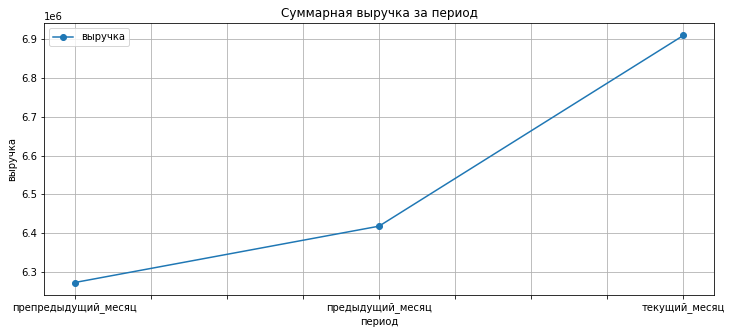

In [34]:
(market_money
                 .pivot_table(index='период', 
                             values='выручка', 
                             aggfunc='sum')
                 .sort_values(by='выручка', ascending=True)
                 .plot(xlabel='период', ylabel='выручка',
                      grid=True, style='o-', figsize=(12, 5), 
                      title='Суммарная выручка за период')
);

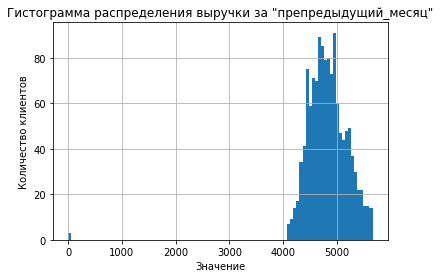

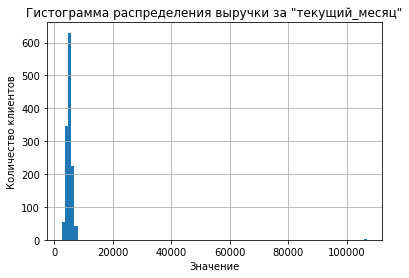

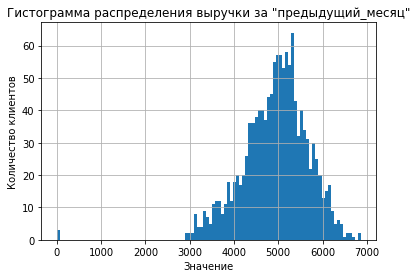

In [35]:
for period in market_money['период'].unique():
    market_money.loc[market_money['период'] == period, 'выручка'].hist(bins=100)
    plt.title(f'Гистограмма распределения выручки за "{period}"')
    plt.xlabel('Значение')
    plt.ylabel('Количество клиентов')
    plt.show();

In [36]:
market_money.loc[market_money['выручка'] == market_money['выручка'].max(), 'id']

98    215380
Name: id, dtype: int64

In [37]:
market_money.query('id == 215380')

,id,период,выручка
96,215380,препредыдущий_месяц,"5,051.000"
97,215380,предыдущий_месяц,"6,077.000"
98,215380,текущий_месяц,"106,862.200"


Суммарная выручка увеличивалась в течение последних 3 месяцев. В каждом периоде есть клиенты, которые не приобретали продукцию (выручка = 0). При этом как мы выяснили ранее клиентов, которые ничего не приобретали все 3 месяца в выборке нет. Чаще всего месячная выручка по клиенту составляет 4-5 тыс. При этом очень выделяется единичный случай, когда выручка по клиенту за текущий месяц превышает 100 тыс. Ранее клиент не приобретал товаров на такую сумму. Теоретически такая ситуация вероятна, в таком случае по данному клиенту также должен быть заметный выброс в прибыли.

In [38]:
display(money.query('id == 215380'))
money['прибыль'].describe()

,id,прибыль
32,215380,3.880


count   1,300.000
mean        3.997
std         1.014
min         0.860
25%         3.300
50%         4.045
75%         4.670
max         7.430
Name: прибыль, dtype: float64

Среднемесячная прибыль по данному клиенту близка к медианному и среднему значениям, следовательно с большей долей вероятности мы имеем дело с аномалией. Т.к. определить истинное значение не представляется возможным, заменим это значение средним показателем выручки за период.

In [39]:
market_money.head(2)

,id,период,выручка
0,215348,препредыдущий_месяц,0.000
1,215348,текущий_месяц,"3,293.100"


In [40]:
market_money.loc[market_money['выручка'] > 100000, 'выручка'] = \
market_money.loc[market_money['период'] == 'текущий_месяц', 'выручка'].mean()

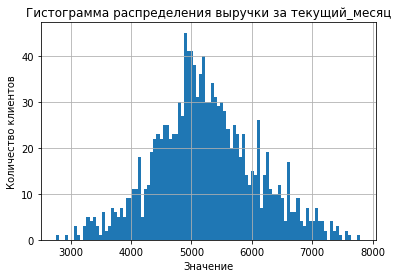

In [41]:
market_money.loc[market_money['период'] == 'текущий_месяц', 'выручка'].hist(bins=100)
plt.title('Гистограмма распределения выручки за текущий_месяц')
plt.xlabel('Значение')
plt.ylabel('Количество клиентов')
plt.show();

После замены аномального значения на среднее распределение по выручке близко к предыдущим периодам.

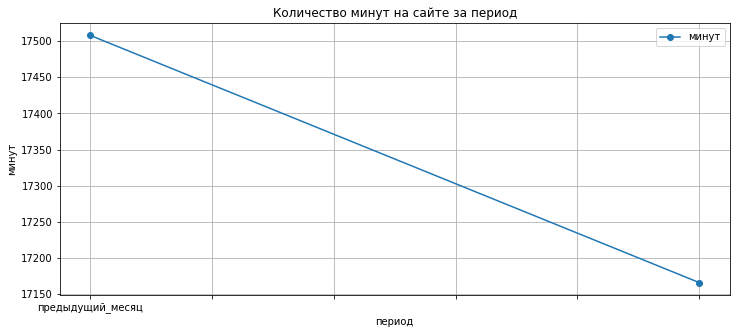

In [42]:
(market_time
                 .pivot_table(index='период', 
                             values='минут', 
                             aggfunc='sum')
                 .sort_values(by='период', ascending=True)
                 .plot(xlabel='период', ylabel='минут',
                      grid=True, style='o-', figsize=(12, 5), 
                      title='Количество минут на сайте за период')
);

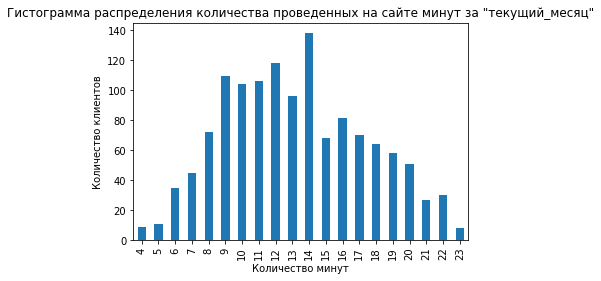

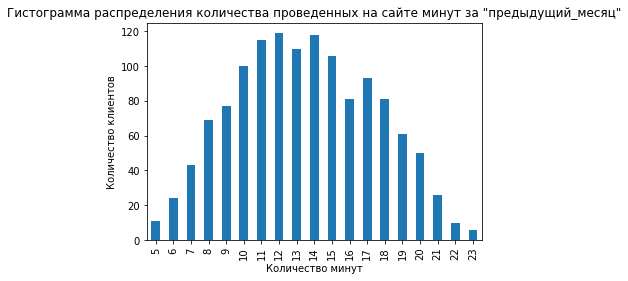

In [43]:
for period in market_time['период'].unique():
    market_time.loc[market_time['период'] == period, 'минут'].value_counts().sort_index().plot(kind='bar') 
    plt.title(f'Гистограмма распределения количества проведенных на сайте минут за "{period}"')
    plt.xlabel('Количество минут')
    plt.ylabel('Количество клиентов')
    plt.show();

Суммарное количество минут, которые клиенты провели на сайте в текущем месяце немного снизилось. График распределения за текущий месяц это подтверждает. Клиентов было немного больше, но в среднем они проводиили меньше времени на сайте.

<b>Вывод по разделу "Исследовательский анализ данных"</b>

В ходе анализа:
1. Аномальное значение в поле `Выручка` за текущий месяц было заменено средним значением выручки за текущий период.
2. В целевой переменной выявлен **дисбаланс классов**.
3. Исходя из найденных закономерностей в данных можно составить **портрет "среднего" покупателя**:
- Дал согласие на получение информации о дополнительных предложениях компании (в среднем получает имеет 4 маркетинговые коммуникации с компанией в месяц)
- Имеет семью
- Совершает покупки вне зависимости от проведения акций
- За один визит просматривает 2-3 категории товаров и до 5 страниц. Проводит на сайте 12-15 минут. 
- В среднем осуществляет покупки на 4-5 тыс в месяц.

## Объединение таблиц

In [44]:
market_money = (market_money
                .pivot_table(index='id', columns='период', values='выручка')
                .rename(columns={'предыдущий_месяц': 'предыдущий_месяц_выручка',
                                 'препредыдущий_месяц': 'препредыдущий_месяц_выручка',
                                 'текущий_месяц': 'текущий_месяц_выручка'})
               )
display(market_money.head(2))

market_time = (market_time
               .pivot_table(index='id', columns='период', values='минут')
               .rename(columns= {'предыдущий_месяц': 'предыдущий_месяц_минуты',
                                 'текущий_месяц': 'текущий_месяц_минуты'})
              )
market_time.head(2)

период,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка
id,,,
215348,0.000,0.000,"3,293.100"
215349,"5,216.000","4,472.000","4,971.600"


период,предыдущий_месяц_минуты,текущий_месяц_минуты
id,,
215348,13,14
215349,12,10


In [45]:
print('Количество строк до объединения:', market_file.shape[0])
print('Суммарное количество колонок до объединения', market_file.shape[1] + market_money.shape[1] + market_time.shape[1])
df_model = market_file.join(market_money).join(market_time)
print('Размер датасета после объединения:', df_model.shape)
df_model.head(2)

Количество строк до объединения: 1300
Суммарное количество колонок до объединения 17
Размер датасета после объединения: (1300, 17)


,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минуты,текущий_месяц_минуты
id,,,,,,,,,,,,,,,,,
215348,снизилась,премиум,да,3.400,5,121,0.000,товары для детей,6,2,1,5,0.000,0.000,"3,293.100",13,14
215349,снизилась,премиум,да,4.400,4,819,0.750,товары для детей,4,4,2,5,"5,216.000","4,472.000","4,971.600",12,10


Проверим таблицу на наличие пропусков и дубликатов. Т.к. мы удалили одно из значений в выручке, в таблице может не хватать данных. Т.к. ранее мы установили, что среднемесячная прибыль по клиенту близка к среднему значению, заполним пропуской средней выручкой за период.

In [46]:
df_model.isna().sum()

покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предыдущий_месяц_выручка               0
препредыдущий_месяц_выручка            0
текущий_месяц_выручка                  0
предыдущий_месяц_минуты                0
текущий_месяц_минуты                   0
dtype: int64

<b>Вывод по разделу "Объединение таблиц"</b>

Таблицы необходимые для разработки модели объединены. Информация о выручке и времени проведенном на сайте выделена в отдельные колонки в соответствии с периодом.

## Корреляционный анализ

Согласно ТЗ проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования.  В нашем случае данные распределены ненормально, поэтому необходимо использовать коэффициент корреляции Спирмена или Кендалла. Ипользуем коэффициент Спирмена.

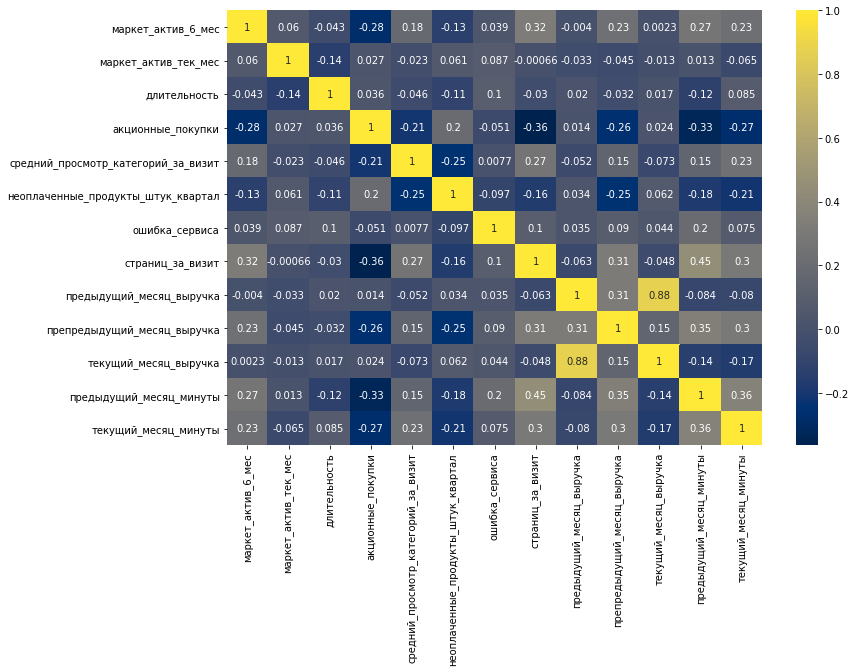

In [47]:
num_columns = df_model.select_dtypes(include='number').columns.tolist()
plt.figure(figsize=(12, 8))
sns.heatmap(df_model[num_columns].corr(method='spearman'), annot=True, cmap='cividis') 
plt.show();

Судя по тепловой карте, самая сильная прямая связь между признаками `предыдущий_месяц_выручка` и `текущий_месяц_выручка`. Коэффициент = 0.88, говорит о высокой корреляции по шкале Чеддока (коэффициент выше 0.7). Исключим при моделировании колонку `текущий_месяц_выручка`, чтобы избежать возможных проблем связанных с мультиколлинеарностью.

<b>Вывод по разделу "Корреляционный анализ"</b>

Удалим признак `текущий_месяц_выручка`, который имеет высокий коэффициент корреляции Спирмена (0.88) с признаком `предыдущий_месяц_выручка`.

## Использование пайплайнов

In [48]:
# RANDOM_STATE = 42
# TEST_SIZE = 0.25

In [49]:
df_model.head(2)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минуты,текущий_месяц_минуты
id,,,,,,,,,,,,,,,,,
215348,снизилась,премиум,да,3.400,5,121,0.000,товары для детей,6,2,1,5,0.000,0.000,"3,293.100",13,14
215349,снизилась,премиум,да,4.400,4,819,0.750,товары для детей,4,4,2,5,"5,216.000","4,472.000","4,971.600",12,10


Т.к. на этапе исследовательского анализа мы отметили, что в целевой переменной присутствует дисбаланс классов, при разбиении данных будем использовать стратифицированные выборки. Для моделей, которые поддерживают этот метод применим class_weights='balanced'.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    df_model.drop(['покупательская_активность', 'текущий_месяц_выручка'], axis=1),
    df_model['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_model['покупательская_активность'])

In [51]:
print('Размер тренировочной выборки', X_train.shape)
print('Размер тестовой выборки', X_test.shape)

Размер тренировочной выборки (975, 15)
Размер тестовой выборки (325, 15)


Закодируем предварительно целевой признак, т.к. метод ColumnTransformer его не преобразовывает. Дял целевого признака используем `LabelEncoder`

In [52]:
label_encoder = LabelEncoder()
y_train_transform = label_encoder.fit_transform(y_train)
y_test_transform = label_encoder.transform(y_test)

Переходим к подготовке пайплайна для предобработки признаков. Подготовим списки с названиями признаков, разделенные по предполагаемому методу обработки. Номинальные признаки `популярная_категория` и `разрешить_сообщать`, которые невозможно ранжировать закодируем с помощью OneHotEncoder. Значения в поле `тип_сервиса` можно проранжировать (стандарт < премиум), поэтому используем для него OrdinalEncoder.  

In [53]:
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = X_train.select_dtypes(include='number').columns.tolist()

In [54]:
num_columns

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'предыдущий_месяц_выручка',
 'препредыдущий_месяц_выручка',
 'предыдущий_месяц_минуты',
 'текущий_месяц_минуты']

Создадим пайплайны для подготовки категориальных признаков.

Используем SimpleImputer для заполнения пропущенных значений. Для энкодеров установим параметр handle_unknown, который позволяет обрабатывать неизвестные категории при необходимости и присваивать им нулевое значение. 

In [55]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

In [56]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

Создаем общий пайплайн для подготовки данных: применяем каждый ранее созданный пайплайн к соответствующим колонкам. К количественным признакам применяем масштабирование.

In [57]:
data_preprocessor = ColumnTransformer(
    [ 
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

Подготовим пайплан для обучения модели (используем модель DecisionTreeClassifier). Итоговый пайплайн включает 2 шага: 

1. Подготовка данных — шаг preprocessor.
2. Инициализация модели DecisionTreeClassifier — шаг models.

In [58]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

Дл масштабирования будем использовать два скейлера: `StandardScaler()` и `MinMaxScaler()` + метод без масштабирования. Зададим варианты масшабирования как гиперпараметр. В дальнейшем для логистической регрессии не будем включать метод без масштабирования, чтобы избежать ситуации когда модель не сходится из-за разброса значений признаков.

In [59]:
param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
} 

Чтобы найти лучшее решение обучим 4 разных модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой подберем гиперпараметры. Для удобства перебор моделей осуществим внутри пайплайна. Для моделей, которые поддерживают этот метод добавим class_weights='balanced'. 

In [60]:
param_grid = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE,
                                          class_weight='balanced')],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            class_weight='balanced',
            solver='saga', 
            penalty='elasticnet',
            max_iter=3000
        )],
        'models__C': range(2, 20),
        'models__l1_ratio': [0, 0.2, 0.5, 0.8, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
     # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE,
                       class_weight='balanced')],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'models__degree': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Осталось запустить автоматический подбор с помощью RandomizedSearchCV. В качестве метрики будем использовать roc-auc. Это позволит оценить качество работы модели вне зависимости от выбранного порога вероятности. К тому же, эта метрика подходит в случае, когда объектов с одним значением целевого признака больше, чем с другими.

In [61]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [62]:
randomized_search.fit(X_train, y_train_transform)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(ste...
                                         'models__C': range(2, 20),
                                         'models__l1_ratio': [0, 0.2, 0.5, 0.8,
                                                              1],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [SVC(class_weight='balanced',
                                                        random_state=42)],
                                         'models__degree': range(1, 10),
                                         'models__kernel': ['linear', 'poly',
                                                            'rbf', 'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [63]:
print('Метрика roc_auc для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('\nЛучшие параметры\n\n', randomized_search.best_params_)

Метрика roc_auc для лучшей модели:
 0.9016346958528777

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                  

In [64]:
result = pd.DataFrame(randomized_search.cv_results_)
result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score').head()

,rank_test_score,param_models,mean_test_score,params
8,1,"LogisticRegression(class_weight='balanced', ma...",0.902,"{'preprocessor__num': StandardScaler(), 'model..."
2,2,"LogisticRegression(class_weight='balanced', ma...",0.902,"{'preprocessor__num': StandardScaler(), 'model..."
3,3,"LogisticRegression(class_weight='balanced', ma...",0.901,"{'preprocessor__num': StandardScaler(), 'model..."
0,4,"LogisticRegression(class_weight='balanced', ma...",0.901,"{'preprocessor__num': StandardScaler(), 'model..."
6,5,KNeighborsClassifier(),0.864,"{'preprocessor__num': MinMaxScaler(), 'models_..."


Лучшей моделью с метрикой **roc-auc = 0.902** оказалась модель `LogisticRegression` со взвешенными классами и параметрами: C=14 и l1_ratio=0.2.

In [65]:
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]

In [3]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_transform, y_test_pred)}')

<b>Вывод по разделу "Использование пайплайнов"</b>

В ходе работы над разделом подготовлен пайплайн:
- данные разделены на тренировочную и тестовую выборку со стратификацией по целевому признаку
- целевой признак закодирован с помощью LabelEncoder
- для обработки категориальных переменных с помощью OneHotencoder и OrdinalEncoder
- для масштабирования количественных признаков использованы 3 разных метода: StandardScaler, MinMaxScaler, без масштабирования
- для поиска лучшего решения были обучены 4 разных модели с подбором гиперпараметров: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). перебор осуществлялся методом RandomizedSearchCV. 
- Для оценки качества была выбрана метрика ROC_AUC.

Лучшая модель - `LogisticRegression` со взвешенными классами и параметрами: C=14 и l1_ratio=0.2.

Метрика roc_auc для лучшей модели при кросс-валидации: 0.9016346958528777

Метрика ROC-AUC на тестовой выборке:0.9145402022147326

## Анализ важности признаков

Оценим важность признаков для лучшей модели. Для этого построим график важности признаков с помощью метода SHAP. Предварительно нужно повторить обработку датасета для подачи методу через тот же пайплайн.

In [67]:
X_train_transformed = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)
X_test_transformed = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()    
) 

Приведем данные полученные через ColumnsTransformer к стандартному датафрейму. Чтобы добавить имена колонок для удобства чтения графика предварительно получим их из пайплайна data_preprocessor.

In [68]:
explainer = shap.Explainer(randomized_search.best_estimator_[-1], X_test_transformed)
shap_values = explainer(X_test_transformed)

Для начала посмотрим на вклад всех признаков в классификацию каждого наблюдения.

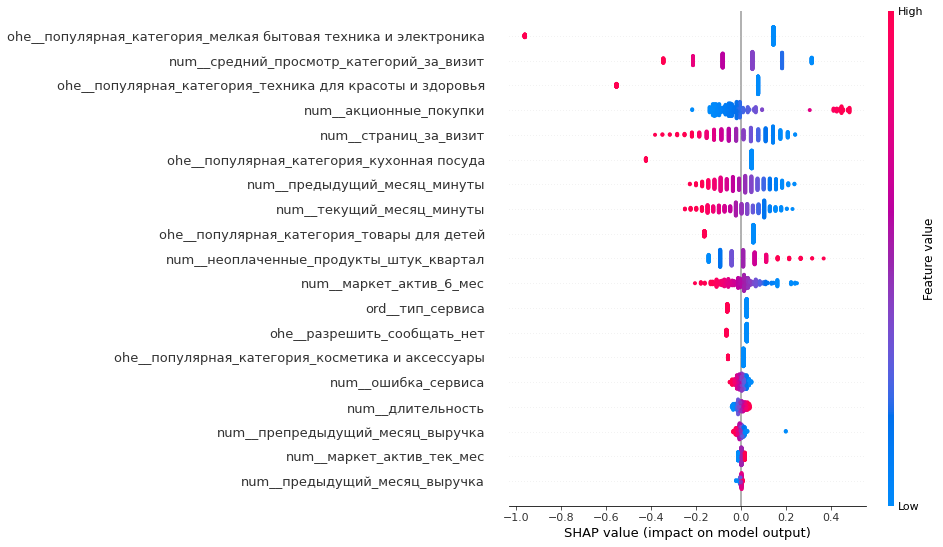

In [69]:
shap.plots.beeswarm(shap_values, max_display=20)

1. Наиболее значимые признаки (по расположению сверху): `Средний_просмотр_категорий_за_визит`, `Страниц_за_визит`, `предыдущий_месяц_минуты`, `текущий_месяц_минуты`.

Если значения в данных полях у наблюдения высокие, то у него высокая вероятность принадлежности к классу 0, т.е. тому, что покупательская активность останется на прежнем уровне. 

Также значимыми влютс признаки `Акционные_покупки` и  `Неоплаченные_продукты_штук_квартал`. Если у клиента большое количество неоплаченных товаров в корзине или много покупок по акции, то у него высокая вероятность принадлежности к классу 1, т.е. снижению покупательской активности.

Здесь мы видим достаточно широкий разброс значений Шепли, что говорит о том, что модель действительно учитывает признаки и уверенно делает предсказания.

2. Менее значимые признаки (ближе к низу): `Маркет_актив_тек_мес`, `предыдущий_месяц_выручка`, `препредыдущий_месяц_выручка`.

Значения Шепли у этих признаков в основном компактны около 0 и не оказывают значительное влияние на классификацию. 


Посмотрим на визуализацию идивидуальных SHAP-значений на примере одного из наблюдений.

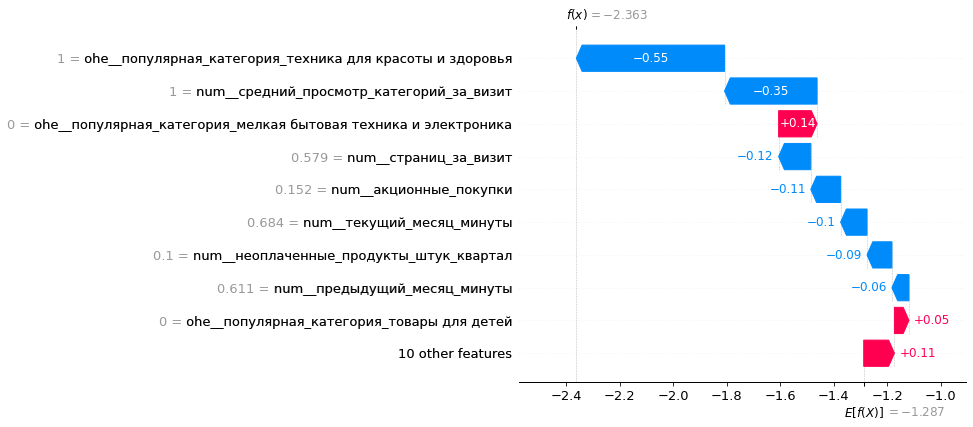

In [70]:
shap.plots.waterfall(shap_values[0]) 

Сильнее всего на классификацию этого наблюдения оказывают влияние признаки, связанные с популярной категорией, а также  `Средний_просмотр_категорий_за_визит`, `Страниц_за_визит` и `Акционные_покупки`. Они позволяют уверенно классифицировать его как 0, т.е. клиента не склонного к снижению покупательской активности. 

<b>Вывод по разделу "Анализ важности признаков"</b>

Анализ важности признаков с помощью SHAP-значений показал, что:

1. Наиболее значимые признаки: `Средний_просмотр_категорий_за_визит`, `Страниц_за_визит`, `предыдущий_месяц_минуты`, `текущий_месяц_минуты`. Чем выше их значение, тем увереннее содель классифицирует клиета как не склонного к снижению покупательской активности.

2. Менее значимые признаки (ближе к низу): `Маркет_актив_тек_мес`, `предыдущий_месяц_выручка`, `препредыдущий_месяц_выручка`.

С точки зрения бизнеса можно сделать вывод, что на покупательскую активность оказывает положительное влияние время проведенное на сайте. Следовательно, можно улучшить персонализацию и стимулировать вовлеченность. Например, добавить рекомендации товаров, интересный контент, показывать больше похожих товаров, предлагать бонусы за просмотр рекламных роликов.

Также видно, что положительно влияет на поддержание покупательской активности высокое значение среднемесячных маркетинговых коммуникаций. Таким образом важно поддерживать маркетинговую активность. Например, регулярно делать персонализированные предложения для активных клиентов в интересных для них категориях товаров.

Можно обратить внимание на, что чем больше неоплаченных товаров, тем ниже вероятность высокой покупательской активности. Возможно, пользователи сталкиваются с проблемами при оплате, стоит дополнительно проанализировать путь клиента. Также можно добавить напоминания о товаре в корзинах или предложить скидку на завершение покупки. Это также повысит количество коммуникаций.

## Сегментация покупателей

В ходе исследовательского анализа мы обратили внимание на наличие выбросов в поле `Прибыль`. Выбросы в верхней части могут представлять ценные клиентские сегменты с высокой прибылью, как и клиенты с высокой прибыльностью в целом. Удержание таких клиентов важно для компании. Выделим группу клиентов с высокой вероятностью снижения покупательской активности и высокой прибыльностью дл дополнительного анализа. Для этого добавим предсказания лучшей модели в исходный датасет и объединим с информацией о прибыли.

In [71]:
df_model_transformed = df_model.drop(['покупательская_активность', 'текущий_месяц_выручка'], axis=1)

In [72]:
df_model['предсказанная_вероятность'] = randomized_search.predict_proba(df_model_transformed)[:, 1]
df_model.head(2)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минуты,текущий_месяц_минуты,предсказанная_вероятность
id,,,,,,,,,,,,,,,,,,
215348,снизилась,премиум,да,3.400,5,121,0.000,товары для детей,6,2,1,5,0.000,0.000,"3,293.100",13,14,0.776
215349,снизилась,премиум,да,4.400,4,819,0.750,товары для детей,4,4,2,5,"5,216.000","4,472.000","4,971.600",12,10,0.919


In [73]:
money = money.set_index('id')
df_model_money = df_model.join(money)
df_model_money.isna().sum()

покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предыдущий_месяц_выручка               0
препредыдущий_месяц_выручка            0
текущий_месяц_выручка                  0
предыдущий_месяц_минуты                0
текущий_месяц_минуты                   0
предсказанная_вероятность              0
прибыль                                0
dtype: int64

Чтобы укрупнить сегмент и выявить больше возможных закономерностей будем считать высокой прибыль выше третьего квартиля (4,67), а значение вероятности выше стандартного порога классификации (0.5).

In [74]:
df_high_profit = df_model_money.query('прибыль > 4.67 and предсказанная_вероятность > 0.5')
df_high_profit.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минуты,текущий_месяц_минуты,предсказанная_вероятность,прибыль
id,,,,,,,,,,,,,,,,,,,
215351,снизилась,стандарт,да,3.200,5,896,0.990,товары для детей,5,0,6,4,"6,158.000","4,793.000","6,610.400",11,13,0.869,4.870
215356,снизилась,стандарт,да,4.200,4,192,0.140,косметика и аксесcуары,2,2,1,3,"4,146.500","4,433.000","4,566.400",6,7,0.941,4.930
215359,снизилась,стандарт,да,4.600,5,110,0.000,домашний текстиль,4,2,4,2,0.000,0.000,"4,735.000",13,11,0.931,5.080
215368,снизилась,премиум,да,3.800,5,829,0.240,техника для красоты и здоровья,2,2,6,1,"5,823.000","4,536.000","5,591.600",11,9,0.887,6.270
215384,снизилась,стандарт,да,4.000,4,1020,0.340,косметика и аксесcуары,2,3,8,3,"3,584.000","4,226.000","4,010.400",11,12,0.925,4.780


Посмотрим какие признаки внутри сегмента сильнее всего коррелируют с прибыльностью.

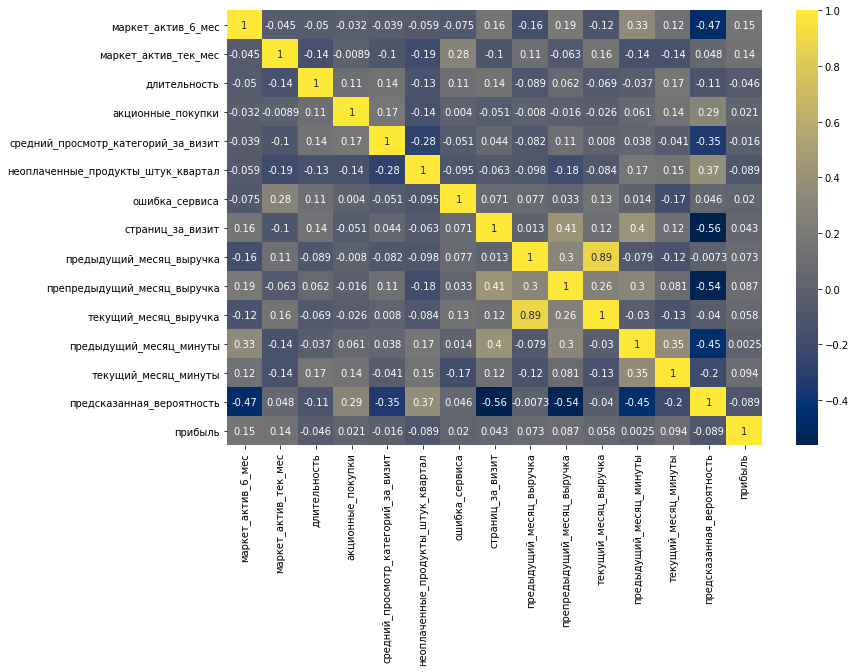

In [75]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_high_profit.corr(method='spearman'), annot=True, cmap='cividis') 
plt.show();

Сильной корреляции между прибылью и признаками не выявлено. Посмотрим на распределения данных внутри сегмента.

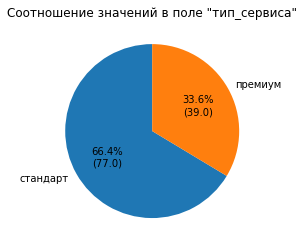

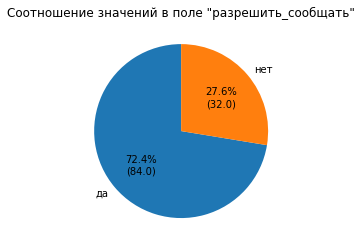

In [76]:
columns = ['тип_сервиса', 'разрешить_сообщать']
category_graph(df_high_profit, columns)

Среди целевой группы распределение по категориальным признакам `тип_сервиса` и `разрешить_сообщать` схоже ранее полученными результатами. Среди клиентов с высокой прибылью чуть больше тех кто предпочитает премиум сервис (34% против 29% в целом) и они чуть чаще отказываются от рекламной рассылки (28% против 26%).

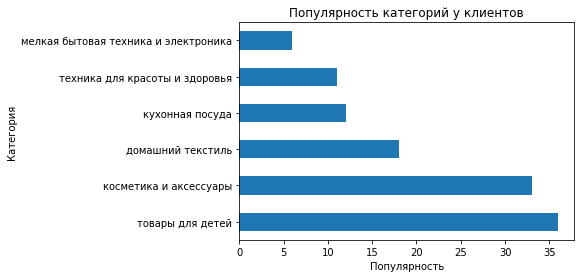

In [77]:
ax = df_high_profit.value_counts('популярная_категория').plot.barh()
plt.title('Популярность категорий у клиентов')
plt.xlabel('Популярность')
plt.ylabel('Категория')
plt.show()

Популярные категории внутри сегмента несколько отличаются от ситуации в целом по клиентам, хотя лидирующую позицию все еще занимают товары для детей. Можно сделать предположение, что техника не приносит высокой прибыли. Возможно, эти товары имеют низкую маржинальность или их приобретают настолько редко, что в общей структуре прибыли они не играют значительной роли.

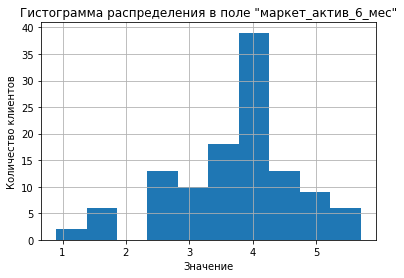

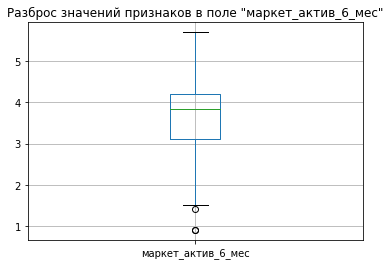

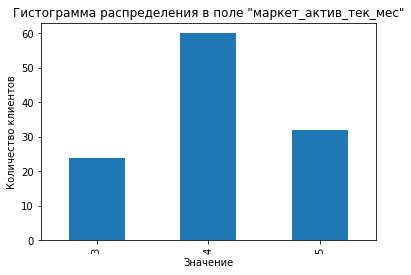

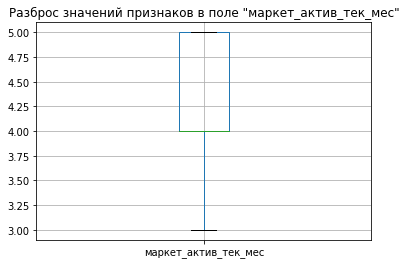

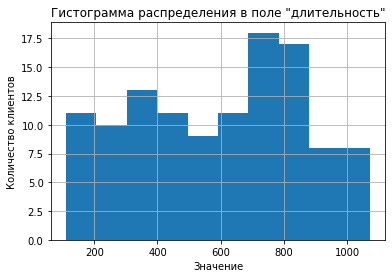

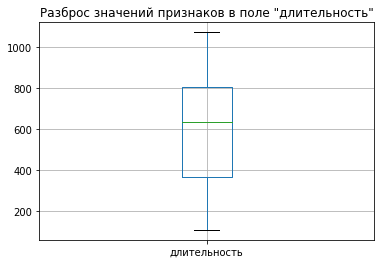

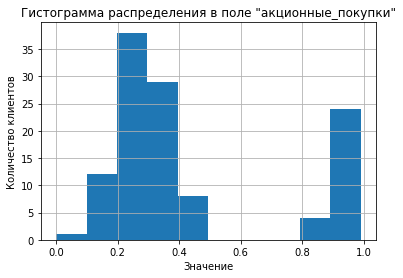

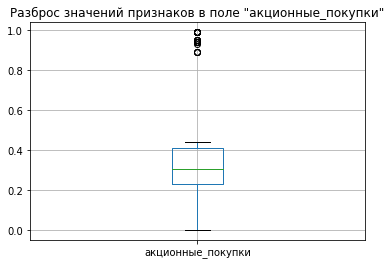

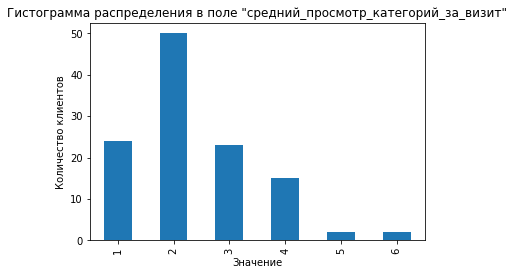

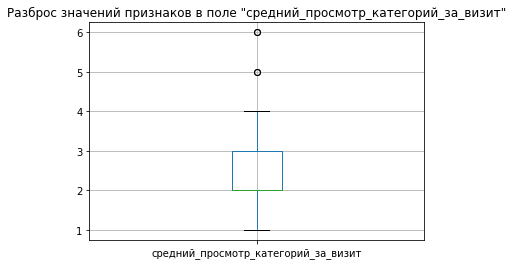

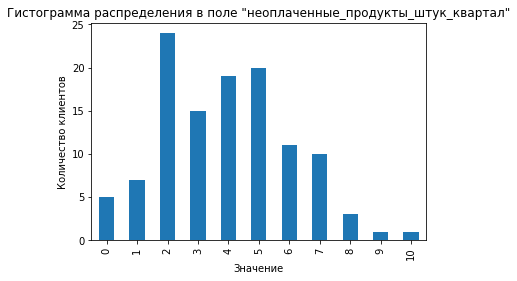

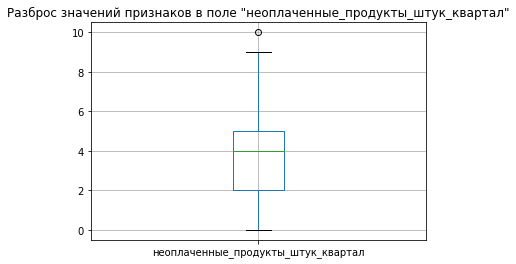

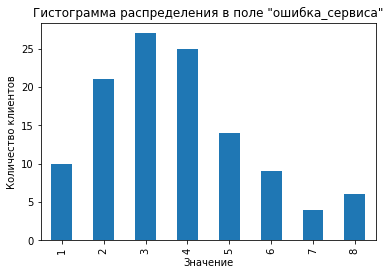

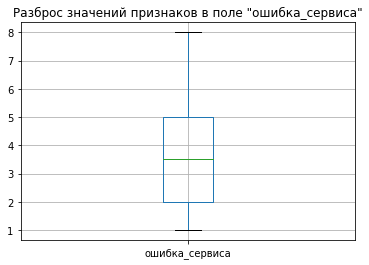

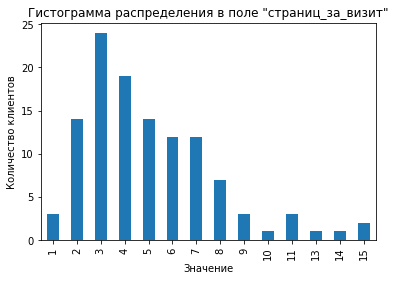

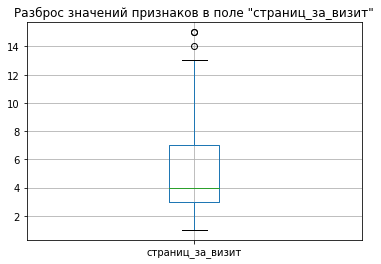

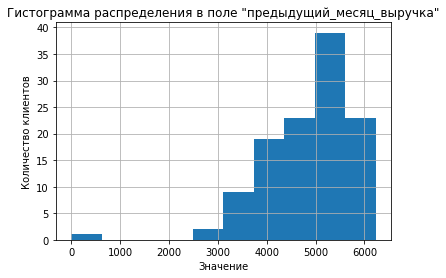

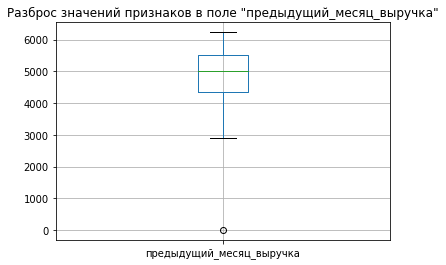

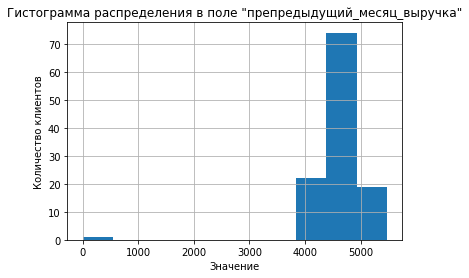

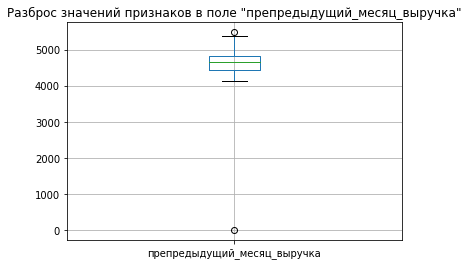

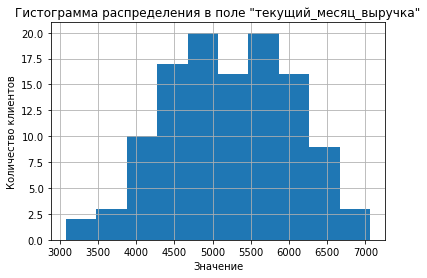

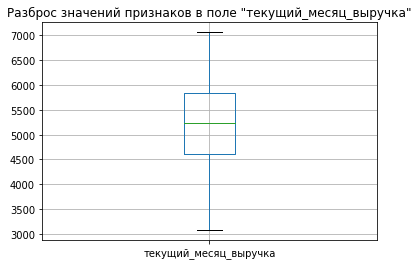

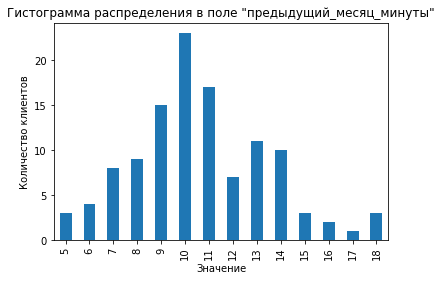

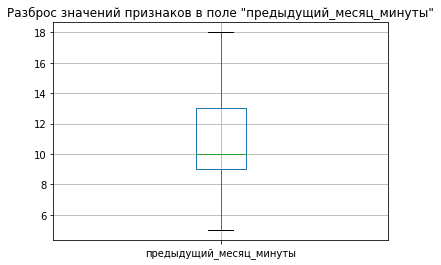

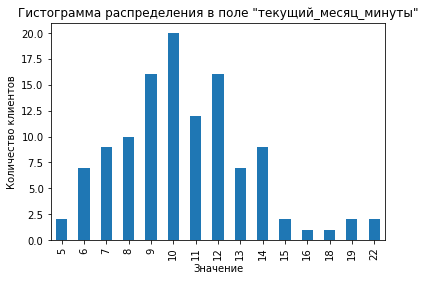

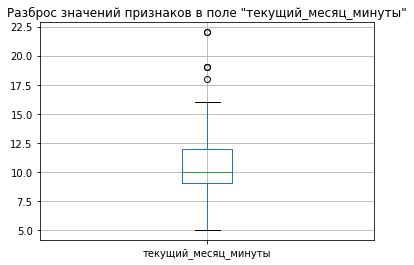

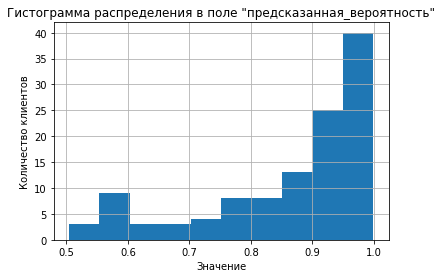

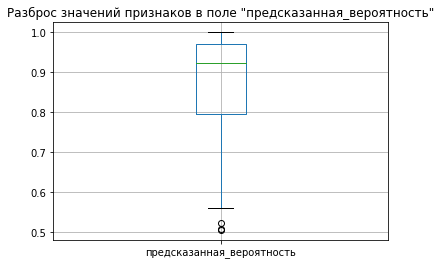

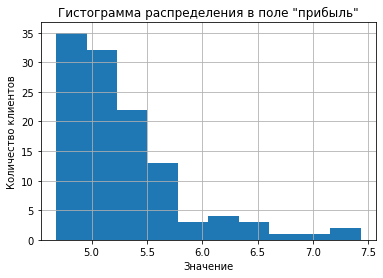

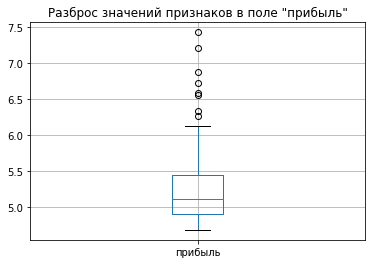

In [78]:
num_columns = df_high_profit.select_dtypes(include='number')
exception_columns = ['длительность']
numeric_graph(df_high_profit, num_columns, exception_columns)

Исходя из полученных графиков можно выделить следующие особенности клиентского сегмента с высокой прибылью и высоким риском снижения покупательской активности по сравнению со всеми клиентами в целом:
- высокая доля тех кто приобретал что-либо на сайте исключительно по акции (доля акционных покупок равна 100%)
- больше доля клиентов с высоким количеством неоплаченных продуктов в корзине (6-7)
- низкое количество посещенных страниц за визит. 

Посмотрим на SHAP-значения для выделенного сегмента.

In [79]:
df_high_profit_transformed = pd.DataFrame(
    data_preprocessor.transform(df_high_profit.drop(columns=['предсказанная_вероятность', 'прибыль'])),
    columns=data_preprocessor.get_feature_names_out()    
) 

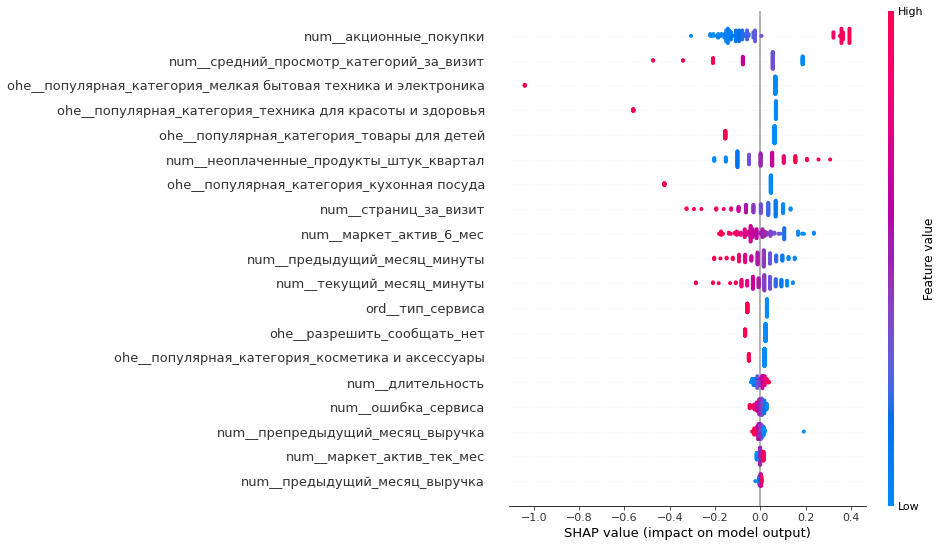

In [80]:
explainer_high_profit = shap.Explainer(randomized_search.best_estimator_[-1], df_high_profit_transformed)
shap_values_high_profit = explainer_high_profit(df_high_profit_transformed)
shap.plots.beeswarm(shap_values_high_profit, max_display=20)

Очень важное значение имеет признак `Акционные покупки`, чем выше доля таких покупок, тем выше вероятность, что покупательская активность снизится.

Также сохраняется важность времени, проведенного на сайте: чем больше посещенных страниц, просмотренных категорий и времени на сайте в целом, тем ниже вероятность снижения активности. Высокое количество неоплаченных покупок и отсутсвие коммуникаций негативно сказывается на активности. Здесь подойдут рекомендации данные выше. 

<b>Вывод по разделу "Сегментация покупателей"</b>

Для дополнительного анализа был выбран сегмент покупателей с высокой прибыльностью (выше 3 квартиля) и высокой вероятностью снижения покупательской активности (выше стандартного порога отсечения). Данный сегмент был выбран с точки зрения важности сохранения прибыльности компании, т.к. именно этот сегмент при успешной работе с ним способен принести значительную часть прибыли.

Исходя из полученных результатов можно дать следующие рекомендации:
1. В связи с высокой долей покупателей ориентированных на акции для их удержания важны:
- Персонализированные предложения – персональные купоны, бонусы за повторные покупки или программы лояльности с накопительной системой скидок.
- Эксклюзивный доступ к акциям –  ранний доступ клиентам премиум-сегмента к распродажам или специальные скидки, недоступные для всех.
Чтобы сохранить таких клиентов, но уменьшить их зависимость от скидок можно предложить бесплатные сервисы (например, ускоренную доставку, расширенную гарантию). А также важно внедрение шагов, описанных ниже.

2. Важным так же является время проведенное на сайте. Для повышения вовлеченности необходимо внедрить/улучшить:
- Рекомендательную систему, которая позволит предлагать дополнительные релевантные товары, связанные категории и персонализированные подборки.
- Геймификация – популярная механика, мотивирующая проводить больше времени на сайте (например, челленджи, накопление бонусов за активность).

3. У сегмента выявлена высокая доля клиентов с большим количеством неоплаченных товаров. Для снижения можно внедрить:
- Напоминания о брошенной корзине: отправка email, push-уведомлений или SMS с напоминанием о незавершенной покупке.
- Покупку в один клик, для упрощения оформления заказа.

## Итоговые выводы

В ходе проекта разработана модель прогнозирования вероятности снижения покупательской активности клиента. На основании результатов модели и данных о прибыли был выделен и проанализирован сегмент покупателей наиболее важных для удержания, с точки зрения сохранения прибыльности компании. Разработаны рекомендации для сохранения покупательской активности клиентов из выделенного сегмента.

В ходе проекта были выполнены следующие этапы:
1. В ходе предобработки:
- имена колонок во всех таблицах были приведены к единому формату
- удалены неявные дубликаты и неточности (поля `Период` и `Тип_сервиса`).
- изменен тип данных в поле `Выручка` на соответствующий данным тип float

2. В ходе подготовки данных к анализу аномальное значение в поле `Выручка` за текущий месяц было заменено средним значением выручки за текущий период.

Выявлен дисбаланс классов в целевом признаке и отсутствие мультиколлинеарности между количественными признаками.

Исходя из найденных закономерностей в данных составлен **портрет "среднего" покупателя**:
- Дал согласие на получение информации о дополнительных предложениях компании (в среднем получает имеет 4 маркетинговые коммуникации с компанией в месяц)
- Имеет семью
- Совершает покупки вне зависимости от проведения акций
- За один визит просматривает 2-3 категории товаров и до 5 страниц. Проводит на сайте 12-15 минут. 
- В среднем осуществляет покупки на 4-5 тыс в месяц.

3. В ходе разработки модели:
- данные разделены на тренировочную и тестовую выборку со стратификацией по целевому признаку
- целевой признак закодирован с помощью LabelEncoder
- категориальные переменные обработаны с помощью OneHotencoder и OrdinalEncoder
- количественные признаки масштабируются с помощью 3 разных методов: StandardScaler, MinMaxScaler, без масштабирования
- для поиска лучшего решения были обучены 4 разных модели с подбором гиперпараметров: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Перебор осуществлялся методом RandomizedSearchCV. 
- Для оценки качества была выбрана метрика ROC_AUC.

**Лучшая модель**:
`LogisticRegression` с параметрами: C=14, class_weight='balanced', l1_ratio=0.2,
                                    penalty='elasticnet', solver='saga'

Метрика ROC-AUC при кросс-валидации: 0.9016346958528777

Метрика ROC-AUC на тестовой выборке: 0.9145402022147326

4. В ходе анализа выбранного сегмента были выявлены следующие особенности клиентов:
- высокая доля тех кто приобретал что-либо на сайте исключительно по акции (доля акционных покупок равна 100%)
- высокая доля клиентов с большим количеством неоплаченных продуктов в корзине
- низкое количество посещенных страниц за визит. 

Среди признаков оказывающих влияние на высокую вероятность снижения покупательской активности можно выделить:
- признак `Акционные покупки`, чем выше доля таких покупок, тем выше вероятность, что покупательская активность снизится.
- время, проведенное на сайте: чем больше посещенных страниц, просмотренных категорий и времени на сайте в целом, тем ниже вероятность снижения активности. 
- высокое количество неоплаченных покупок и отсутствие коммуникаций негативно сказывается на активности. 

**Рекомендации**:
1. Для удержания клиентов, ориентированных на акции:
- Персонализированные предложения – купоны, бонусы за повторные покупки или программы лояльности с накопительной системой скидок.
- Эксклюзивный доступ к акциям – ранний доступ клиентам премиум-сегмента к распродажам или специальные скидки, недоступные для всех.
- Для уменьшения зависимости от скидок предложить бесплатные сервисы (ускоренная доставку, расширенная гарантия).

2. Для повышения вовлеченности клиентов:
- Рекомендательная система для предложения дополнительных товаров, связанных категорий и персонализированных подборок.
- Геймификация, мотивирующая проводить больше времени на сайте (челленджи, накопление бонусов за активность).

3. Для снижения количества неоплаченных товаров:
- Напоминания о брошенной корзине: отправка email, push-уведомлений или SMS с напоминанием о незавершенной покупке.
- Покупка в один клик, для упрощения оформления заказа.